<center> 
    <h3><b> Adnan Rashid </b></h3>
    <nav>
    | <a href="00-Contents-Setup.ipynb"> Home Page </a> | 
    <a href="http://bit.ly/cka_notes_original"> Kubernetes Notes </a> |
    <a href="https://adnan.study"> Website </a> |
    <a href="https://www.instagram.com/adnans_techie_studies/"> Instagram </a> |
    <a href="https://www.linkedin.com/in/adnanrashid1/"> LinkedIn </a> |
    </nav>

</center>

<center><h1 style="background:black"><code style="background:black;color:white">Health Checks</code></h1></center>

<div class="alert alert-block alert-warning">
<font style="color:black">
<center> By default, Kubernetes will restart a container if it crashes for any reason. <br><br> It uses Liveness and Readiness probes which can be configured for running a robust application by identifying the healthy containers to send traffic to and restarting the ones when required. <br><br> In this section, we will understand how liveness and readiness probes are defined and test the same against different states of a pod. 
</center>
</font>
</div>

<center><img src="https://adnanstudyimages.s3-eu-west-1.amazonaws.com/13.jpg" width="50%" height="50%" border=5/></center>

* [Configure the Liveness Probe](#liveprobe)
* [Introduce a failure](#liveprobefail)
* [Configure readiness Probe](#readinessprobe)
* [Introduce a failure](#readinessprobefail)
* [Restoring the pod status](#restorepod) 
* [Clean up](#readinesscleanup)

<blockquote>

* <b>Liveness probes </b> are used in Kubernetes to know when a pod is alive or dead. A pod can be in a dead state for a variety of reasons; Kubernetes will kill and recreate the pod when a liveness probe does not pass.

* <b>Readiness probes</b> are used in Kubernetes to know when a pod is ready to serve traffic. Only when the readiness probe passes will a pod receive traffic from the service; if a readiness probe fails traffic will not be sent to the pod.

<br>

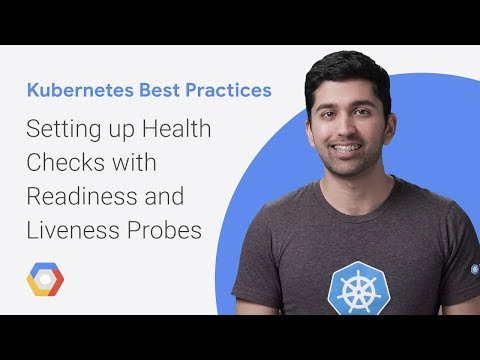

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo('mxEvAPQRwhw')

## Pre-requisite

* Check your variables are loaded

In [ ]:
%store

* Load in variable store

In [ ]:
%store -r 

* Load variables into notebook

In [ ]:
%env AWS_PROFILE=$AWS_PROFILE
%env AWS_DEFAULT_REGION=$AWS_DEFAULT_REGION
%env ACCOUNT_ID=$ACCOUNT_ID

* Check identity 

In [ ]:
!aws sts get-caller-identity

<br>

---
---

<br>

## <br><br>Configure the Liveness Probe <a class="anchor" id="liveprobe"></a>

In [ ]:
!cat healthchecks/liveness-app.yaml 

<br><br>In the configuration file above, the <mark>livenessProbe</mark> determines how kubelet should check the container in order to consider whether it is healthy or not.

kubelet uses the <mark>periodSeconds</mark> field to do frequent check on the container - every 5 seconds in this case.

The <mark>initialDelaySeconds</mark> field is used to tell kubelet that it should wait for 5 seconds before doing the first probe 

To perform a probe, kubelet sends a <mark>HTTP GET</mark> request to the server hosting this pod and depending on the handler for the servers <mark>/health</mark> returns a success code, then the container is considered healthy. 

If the handler returns a failure code, the kubectl kills the container and restarts it. 

* Create a pod with liveness probe

In [ ]:
!kubectl apply -f healthchecks/liveness-app.yaml

* Currently 0 restarts

In [ ]:
!kubectl get pod liveness-app

* <b>kubectl describe</b> command will show an event history which will show any probe failures or resetarts

In [ ]:
!kubectl describe pod liveness-app

## <br><br>Introduce a failure to Liveness Probe <a class="anchor" id="liveprobefail"></a>

* We will run the next command to send a SIGUSR1 signal to the nodejs application. 

By issuing this command we will send a kill signal to the application process in the docker runtime

In [ ]:
!kubectl exec -it liveness-app -- /bin/kill -s SIGUSR1 1 

* Wait a few seconds and then look at the last few lines 

In [ ]:
!kubectl describe pod liveness-app

When the nodejs app entered a debug mode with SIGUSR1 signal, it did not respond to the health check pings and kubelet killed the container. 

* The container was subject to the default restart policy

In [ ]:
!kubectl get pod liveness-app

* Check the status of the container health checks 

In [ ]:
!kubectl logs liveness-app

* We can also use <b> kubctl logs </b> to retrieve logs from a previous instantiation of a container with <b>--previous </b> flag, in case the container has crashed

In [ ]:
!kubectl logs liveness-app --previous

## <br><br>Configure Readiness Probe <a class="anchor" id="readinessprobe"></a>

<br><Br>The <b>readinessProbe</b> definition explains how a linux command can be configured as healthcheck. 

* We create a empty file <b>/tmp/healthy</b> to configure the readiness probe and use the same to understand how kubelet helps to update a deployment with only healthy pods

In [ ]:
!cat healthchecks/readiness-deployment.yaml 

* Create a deployment to test readiness probe. 

In [ ]:
!kubectl apply -f healthchecks/readiness-deployment.yaml

* This creates a deployment with 3 replicas and readiness probe as describing in the beginning

In [ ]:
!kubectl get pods -l app=readiness-deployment

* Confirm replicas are able to serve traffic when a service is pointed to this deployment

In [ ]:
!kubectl describe deployment readiness-deployment | grep Replicas: 

## <br><br> Introduce a Failure to Readiness Probe <a class="anchor" id="readinessprobefail"></a>

* Pick one of the pods from the above 3 and issue a command as below to delete the <b>/tmp/healthy</b> file which makes the readiness probe fail. 

In [ ]:
!kubectl exec -it <POD NAME> -- rm /tmp/healthy

<br><br>We deleted the <b>/tmp/healthy</b> file which makes the readiness probe fail. 

* The file must be present for the readiness check to pass. Lets check the status after issuing the above

In [ ]:
!kubectl get pods -l app=readiness-deployment

<br><br>You can see traffic will not be routed to the first pod 

The ready column confirms that the readiness probe for this pod did not pass and hence was marked as not ready. 

* We will now check for the replicas that are available to serve traffic when a service is pointed to this deployment 

In [ ]:
!kubectl describe deployment readiness-deployment | grep Replicas: 

## <br><br>Restoring the pod status <a class="anchor" id="restorepod"></a>

* Recreate the <b> /tmp/healthy </b> file

Once the pod passes the probe it gets marked as ready and will begin to receive traffic again. 

In [ ]:
!kubectl exec -it readiness-deployment-589b548d5-cbl62 -- touch /tmp/healthy

* We can see the pods are healthy again now

In [ ]:
!kubectl get pods -l app=readiness-deployment

## <br><br>Clean up <a class="anchor" id="readinesscleanup"></a>

Our Liveness probe example used HTTP request and Readines probe executed a command to check health of a pod 

The same can be accomplished using a TCP request

In [ ]:
!kubectl delete -f healthchecks/liveness-app.yaml 
!kubectl delete -f healthchecks/readiness-deployment.yaml